# Método de colocación con PyTorch

En este notebook se implementa el método de colocación
minimizando el error cuadrático medio del residual
en los puntos de colocación.

Adicionalmente, se hace uso de la diferenciación automática
para calcular el residual.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad
import torch.nn as nn


## Problema a resolver

Queremos resolver la siguiente ecuación diferencial

$$\frac{d^2u}{dx^2} + u + x = 0 \enspace , $$

con condiciones de frontera $u(0)=u(1)=0$, que tiene
como solución exacta

$$u_e(x) = \frac{\sin(x)}{\sin(1)} - x \, .$$

## Función de aproximación propuesta

En este caso, hacemos uso de una función de aproximación
polinómica

$$u_N(x) = \sum_{i=0}^N c_i \phi_i(x) = x (1-x) \sum_{i=0}^N c_i x^i\, ,$$

en donde vemos que esta función satisface las condiciones de frontera.

In [6]:
def calculate_first_n_legendre_polynomials(x: torch.Tensor, n: int) -> torch.Tensor:
    # Inicializa los dos primeros polinomios de Legendre
    legendre_polynomials = [torch.ones_like(x), x]

    # Calcula los polinomios de Legendre hasta el grado n
    for _ in range(2, n + 1):
        # Coeficientes para la relación de recurrencia de los polinomios de Legendre
        a = (2 * _ - 1) / _
        b = (_ - 1) / _

        # Calcula el polinomio de Legendre de grado i usando la relación de recurrencia
        legendre_polynomial = a * x * legendre_polynomials[-1] - b * legendre_polynomials[-2]

        # Añade el polinomio de Legendre de grado i a la lista
        legendre_polynomials.append(legendre_polynomial)

    # Devuelve los polinomios de Legendre como un tensor de PyTorch
    return torch.stack(legendre_polynomials, dim=1)

In [7]:
class OrthogonalNeuralNetwork(nn.Module):
    def __init__(self, n: int, lb: float, ub: float):

        super(OrthogonalNeuralNetwork, self).__init__()
        self.n = n
        self.lb = lb
        self.ub = ub
        
        # Inicializa los coeficientes como parámetros del modelo que se aprenderán durante el entrenamiento
        self.weights = nn.Parameter(torch.zeros(n+1))
         

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # Normaliza la entrada
        x = 2 * (x - self.lb) / (self.ub - self.lb) - 1

        # Calcula los polinomios de Legendre hasta el grado especificado
        legendre_polynomials = calculate_first_n_legendre_polynomials(x, self.n)

        # Selecciona los polinomios de Legendre necesarios para la aproximación
        selected_legendre_polynomials = legendre_polynomials[:, :self.n + 1]

        # Realiza una combinación lineal de los polinomios de Legendre seleccionados utilizando los coeficientes aprendidos
        return torch.atan(torch.matmul(selected_legendre_polynomials, self.weights[:self.n + 1]))

In [ ]:
def forward(x: torch.Tensor) -> torch.Tensor:


    # Calcula los polinomios de Legendre hasta el grado especificado
    legendre_polynomials = calculate_first_n_legendre_polynomials(x, n)

    # Selecciona los polinomios de Legendre necesarios para la aproximación
    selected_legendre_polynomials = legendre_polynomials[:, :n + 1]

    # Realiza una combinación lineal de los polinomios de Legendre seleccionados utilizando los coeficientes aprendidos
    return torch.atan(torch.matmul(selected_legendre_polynomials, weights[:n + 1]))

In [8]:
def funcion_aprox(x, c):
    """Función de aproximación con coeficientes c y variable x"""
    terms = [coef * x**(i + 1) * (1 - x) for i, coef in enumerate(c)]
    return torch.sum(torch.stack(terms), dim=0)


Y el residual estaría dado por

$$R = \frac{d^2 u_N}{dx^2} + u_N + x\, .$$


## Uso de diferenciación automática

En lugar de calcular el residuo análiticamente se obtiene con diferenciación automática.

In [3]:
# Derivada
def derivative(dy, x, order=1):
    for _ in range(order):
        dy = grad(dy, x, grad_outputs=torch.ones_like(dy), create_graph=True, retain_graph=True)[0]
    return dy

# Residuo
def residuo(x, c):
    return derivative(funcion_aprox(x, c), x, order=2) + funcion_aprox(x, c) + x

# Función de pérdida: error cuadrático medio
def loss_fn(x, c):
    res = residuo(x, c)
    return torch.mean(res ** 2) 


# Inicialización de coeficientes de forma aleatoria
def initialize_coefficients(n):
    std_dev = 1.0 / torch.sqrt(torch.tensor(n, dtype=torch.float32))
    return torch.randn(n) * std_dev

In [4]:
npts = 4
x_coloc = torch.tensor([(cont + 1)/(npts + 1) for cont in range(npts)],
                       requires_grad=True)

c = initialize_coefficients(npts).requires_grad_(True)

In [5]:
# Configuración del optimizador
optimizer = torch.optim.Adam([c], lr=0.1)

# Bucle de entrenamiento
num_epochs = 1_000
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Limpiar gradientes previos
    current_loss = loss_fn(x_coloc, c)  # Calcular la pérdida
    losses.append(current_loss.item())
    current_loss.backward()  # Calcular gradientes
    optimizer.step()  # Actualizar parámetros

    if epoch % 100 == 0:  # Mostrar progreso cada 1000 épocas
        print(f'Epoch {epoch}, Loss: {current_loss.item():g}')

# Resultados optimizados
print(f'Optimized c: {c.data}') 

Epoch 0, Loss: 2.44453
Epoch 100, Loss: 0.000736621
Epoch 200, Loss: 0.0005507
Epoch 300, Loss: 0.000403465
Epoch 400, Loss: 0.000276107
Epoch 500, Loss: 0.000177268
Epoch 600, Loss: 0.000106995
Epoch 700, Loss: 6.0761e-05
Epoch 800, Loss: 3.24623e-05
Epoch 900, Loss: 1.63055e-05
Optimized c: tensor([ 0.1852,  0.2084, -0.0501,  0.0171])


Gráfica de la predicción obtenida.

In [6]:
x = torch.linspace(0, 1, steps=100)
y_pred = funcion_aprox(x, c).detach().numpy()
y_true = np.sin(x)/np.sin(1) - x

Text(0, 0.5, 'u(x)')

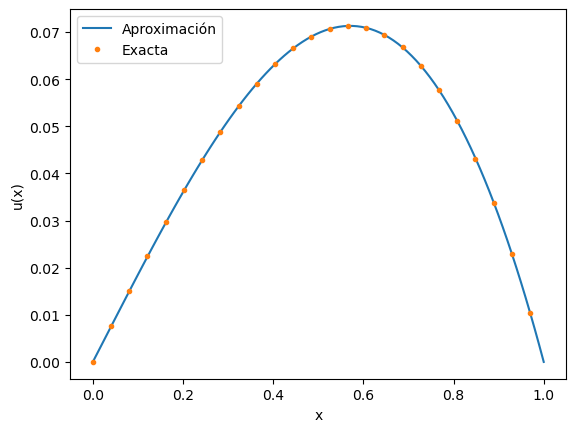

In [7]:
fig = plt.figure()
plt.plot(x, y_pred)
plt.plot(x, y_true, ".", markevery=4)
plt.legend(['Aproximación', 'Exacta'])
plt.xlabel("x")
plt.ylabel("u(x)")

Gráfica el residuo obtenido luego de la optimización.

Text(0.5, 0, 'x')

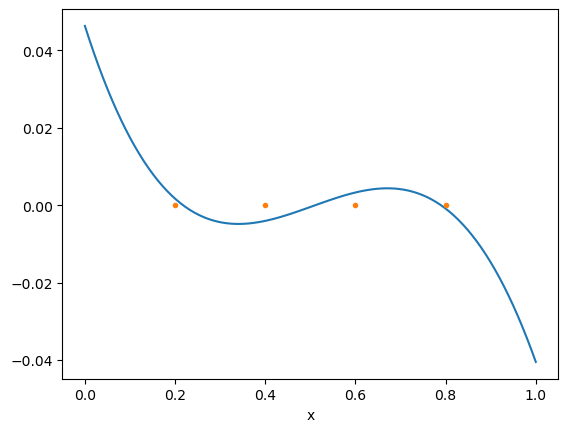

In [8]:
x.requires_grad_(True)

fig = plt.figure()
plt.plot(x.detach().numpy(), residuo(x, c).detach().numpy())
plt.plot(x_coloc.detach().numpy(), [0]*npts, ".")
plt.xlabel("x")


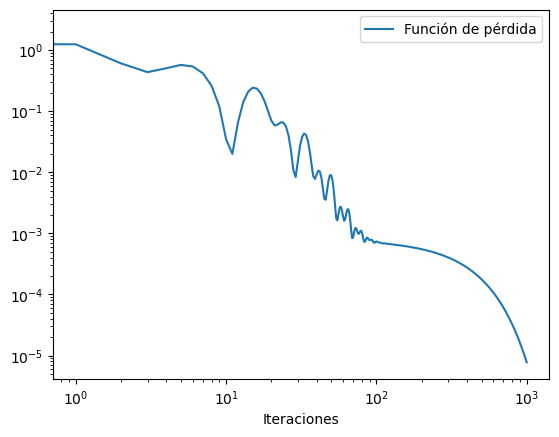

In [9]:
fig, ax = plt.subplots()
plt.loglog(losses)
plt.xlabel("Iteraciones")
plt.legend(['Función de pérdida'])